## **Adaptive Neuro-Complex Fuzzy Inference System**

The following implementation of ANCFIS is inspired by "*ANCFIS: A Neuro Fuzzy Architecture Employing Complex Fuzzy Sets*", by Chen et al (2011). Such architecture is based on previous work by Jang (1993), who first introduced a neural network approach for rule inference in a type-3 (Takagi-Sugeno) Fuzzy Inference System.
<br> <br>
Complex fuzzy logic, as first introduced by Ramot et al (2003), is an extension of fuzzy logic to the complex domain by means of membership functions mapping inputs to degrees of membership on the complex unit disk. Ramot suggested that problems dealing with periodic or recurring phenomena, such as representing solar activity (analyzed here) or the effect of financial indicators on each other (final objective of this thesis), can be modeled more faithfully by using the phase component of CFS memberships.
<br> <br>
Code implementation is based upon the work of Professor James F. Power, available at https://github.com/jfpower/anfis-pytorch/blob/master/experimental.py. 

#### **Premise parameter optimization**
To update premise parameters Variable Neighbor Chaotic Simulated Annealing (VNCSA) is used as described in Chen et al (IEEE TRANSACTIONS ON FUZZY SYSTEMS, VOL. 19, NO. 2, APRIL 2011, page 309). The search algorithm is implemented in vncsa.py.

#### **Network structure**
#### *Variable Fuzzification*
Variable fuzzification refers to the computation of the sampled membership functions. The **FuzzifyVariable** class is used to compute, store, and update membership functions and parameters associated with a given variable. Sampled memberships and corresponding parameters are stored as attributes of the class. The *forward* method computes the sampled membership in Cartesian form and stores it into the *cmf* attribute. The membership function used is the sine function as defined by S. Dick in "Toward Complex Fuzzy logic" (2005). The possibility to choose another membership function, such as Gaussian membership, will be added. FuzzifyVariable also has a *backward* method which takes as input an objective membership function and updates the function parameters so as to minimize the supremum norm between the new membership and the objective. The objective membership is itself obtained by updating the previous membership according to its gradient as given by the backward pass on the model.

#### *Layer 1: Layer Fuzzification*
The first layer is initilized through the membership function as obtained by calling the *forward* method on FuzzifyVariable objects. The forward pass computes the convolution between input vector and sampled membership, outputing the result as normilized by Elliot's Function.

#### *Layer 2: Firing Strenght Layer*
As described in Chen et al (2011). For the univariate case this layer simply returns its inputs. 

#### *Layer 3: Normalization Layer*
Normalizes inputs.

#### *Layer 4: Dot Product Layer*
Computes and returns the real weights to be used for fitting coefficients of linear consequent and perform weighted sum in final layer.

#### *Layer 5: Linear Consequent Layer*
In the linear consequent layer the crisp component of a Takagi-Sugeno fuzzy rule is computed through linear regression. Being time series forecasting the final goal of the model, this crisp output can be seen as the output an autoregressive model. According to this view the ANCFIS model becomes a means of weighting different autoregressive models to produce a final prediction output. Therefore, a straightforward improvement would be to substitute the AR process used here with other, more effective, autoregressive models such as ARIMA or GARCH. 

#### *Layer 6: Weighted Sum Layer*
The previous layer is structured so as to output the weighted regression outputs for each rule. Even though the naming convention used in ANCFIS literature was followed, rather than a weighted sum this layer computes a simple sum of previous layer outputs.

#### **Training Loop Structure**
The first step is to compute the size of training batches to be later used in gradient computation. This choice was forced by the fact that pytorch accumulates gradients in leaf nodes in successive backward computation. As the final output model is structured so as to take a single invput vector of previous observation, gradient computation has to be performed by recursively passing consecutive input vectors. Given that pytorch accumulates gradients in the leaf nodes of the model, after each consecutive input vector is passed, a sum of leaf node gradients is stored in the grad attribute of leaf tensors. Dividing this gradient by the number of input vector returns an average gradient, which is then used for adapting model parameters, a.k.a. membership functions.<br><br>
In a succesive step, the optimizer, the loss function, and the model are all initialized.<br>
The loop starts iterating over training epochs. A DataLoader object defined on the custom IterableDataset class is used to retrieve each training batch. In this implementation, a single batch per training epoch is used. At each training epoch previous errors are checked by the *adapt_lr* function to determine if learning rate needs to be adjusted as described in Jang (1993).<br> A forward pass is performed on the model and resulting rule-weights are stored in a correspinding attribute of DotProductLayer. These are then used to compute Linear Consequent parameters by means of ordinary least squares linear regression.<br> After completing this first step of the hybrid learing procedure, a second forward pass on the model with optimized linear consequent is performed to obtain model outputs and compute the corresponding loss function. Backward pass is then performed and the objective membership function obtained. Such membership is then given as input to the VNCSA as described in the *Fuzzification* Section above to update the complex membeship parameters.

### Import default and custom libraries

In [1]:
# Machine Learning
import torch
from torch import nn
import torch.nn.functional as F

# Data (pre)processing
from torch.utils.data import DataLoader, IterableDataset
import numpy as np
import pandas as pd

# Utils
from collections import OrderedDict

# Finance utils
from pandas_datareader import data as pdr
import yfinance as yfin

# Plots
import matplotlib.pyplot as plt

# Custom libraries
from vncsa import *
from ancfislib import *

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initailize data for testing

The data sample used here is the same sunspot dataset used in Chen et al (2011)


[*********************100%%**********************]  1 of 1 completed


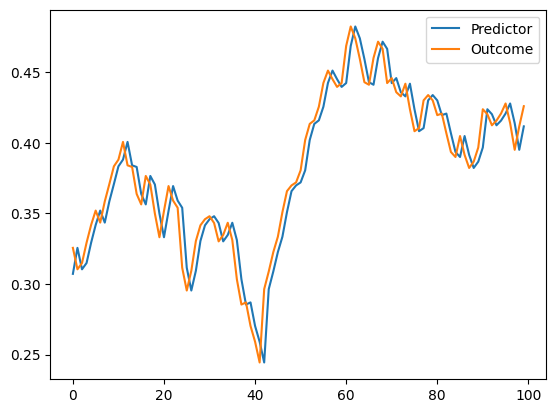

In [2]:
# Download data sample
tickers = ["^IXIC"]
start_date = "1970-05-01"
end_date = "2023-03-14"

yfin.pdr_override()
data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
close = data['Close']

train_test_split = 0.8
train_test_index = round((train_test_split)*len(close))
x = close.values[:train_test_index]

# Normalize based on train with regression on log(price)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.arange(len(x)).reshape(-1,1), np.log(x).reshape(-1,1))
# plt.plot(reg.predict(np.arange(len(close)).reshape(-1,1)), color = 'red')
# plt.plot(np.log(close.values))
normalized_data = np.log(close.values) - reg.predict(np.arange(len(close)).reshape(-1,1)).reshape(len(close))
# plt.plot(normalized_data)
predictor = normalized_data[:-1]
tao = 1
outcome = pd.Series(normalized_data).shift(-tao)[:-1].values

x_train = torch.tensor(predictor[:round((train_test_split)*len(close))])
x_test = torch.tensor(predictor[round((train_test_split)*len(close)):])
y_train = torch.tensor(outcome[:round((train_test_split)*len(close))])
y_test = torch.tensor(outcome[round((train_test_split)*len(close)):])

# Define function to create delay vector
def delay_vector(x:np.array, tao, dim):
    delay = []
    for j in range(1,len(x)-tao*dim + tao + 1):
        k = []
        for i in range(dim):
            k.append(x[-1-i*tao])
        x = x[:-1]
        delay.append(k[::-1])
    return np.array(delay[::-1])
    
plt.plot(predictor[:100], label = 'Predictor')
plt.plot(outcome[:100], label = 'Outcome')
plt.legend()

The logic of the dataset iterator below is to reorganize the input vector into a matrix of rolling input vectors of fixed lenght.
The idea is to obtain a matrix of observations $X \in \mathbb{R}^{m \times n}$ and a vector of targets $y \in\mathbb{R}^m$, where:
- **n** is the lenght of each individual vector of consequtive observations
- **m** = N - n,  is the number of input vector observations, where N is the number of total individual observations <br>
<br>
The iterator then iterates over batched samples of observations and targets

In [3]:
# Implement IterableDataset to use in training loop
class IterableData(IterableDataset):
    def __init__(self, window:int, x:torch.Tensor, y:torch.Tensor, num_batches = 10, delay=False, tao=tao):
        super(IterableData).__init__()
        self.data = (x,y)
        self.window = window
        self.num_batches = num_batches
        if delay:
            dim = window
            delay_len = tao*(dim-1)
            self.X = torch.tensor(delay_vector(x, tao, dim)).unsqueeze(0)
            self.y = y[delay_len:].unsqueeze(0)
        else:
            self.shifts = x.shape[0] - self.window
            self.X = torch.stack([x.roll(-s)[:window].reshape(window) for s in range(self.shifts)])\
            .reshape(self.num_batches, self.shifts//self.num_batches, self.window)  
            self.y = y[self.window:]
            self.y = self.y.reshape(1,*self.y.shape).reshape(self.num_batches, self.shifts//self.num_batches)
        self.iter = iter(range(self.num_batches))
    
    def __len__(self):
         return self.data[0].shape[0]

    def __iter__(self):
            idx = next(self.iter)
            yield self.X[idx], self.y[idx]

dataset = IterableData(40, x_train, y_train, delay=True)
iterator = iter(dataset)
u,v = next(iterator)


#### Implement Training Loop  

In [4]:
# Define function to perform learning rate adaptation according to changes in RMSE per each epoch
def adapt_lr(errors:list, lr, increase_rate:float = 0.1, decrease_rate:float = 0.1, m:int = 4):
    new_lr = None
    count_down = []
    count_up = []
    if len(errors) == 0:
        pass
    else:
        if len(errors) > m:
            for i in range(1,m+1):
                if errors[-i] - errors[-i-1] <= 0:
                    count_down.append(1)
                    count_up.append(0)
                else:
                    count_up.append(1)
                    count_down.append(0)
    if count_down == [1,1]*m:
        new_lr = lr*(1-decrease_rate)
    if count_up == [0,1]*(m) or count_up == [1,0]*(m):
        new_lr = lr*(1+increase_rate)

    return new_lr

# Initalize some variables for plotting later
errors = []
linear_coefficients = []
cmf_params = []

def calc_error(y_pred, y_actual):
    with torch.no_grad():
        tot_loss = F.mse_loss(y_pred, y_actual)
        rmse = torch.sqrt(tot_loss).item()
        perc_loss = torch.mean(100. * torch.abs((y_pred - y_actual)
                               / y_actual))
    return(tot_loss, rmse, perc_loss)

def plotErrors(errors):
    '''
        Plot the given list of error rates against no. of epochs
    '''
    plt.plot(range(len(errors)), errors, '-ro', label='errors')
    plt.ylabel('Percentage error')
    plt.xlabel('Epoch')
    plt.show()


def plotResults(y_actual, y_predicted):
    '''
        Plot the actual and predicted y values (in different colours).
    '''
    plt.plot(range(len(y_predicted)), y_predicted.detach().numpy(),
             'r', label='trained')
    plt.plot(range(len(y_actual)), y_actual.numpy(), 'b', label='original')
    plt.legend(loc='upper left')
    plt.show()

def train_anfis_with(window, X_train , y_train, mf_params, nmfs, num_batches, 
                     m, increase_rate_lr, decrease_rate_lr, epochs=10, show_plots=False):
    '''
        Train the given model using the given (x,y) data.
    '''
    batch_size = len(X_train)/num_batches
    # Initalize membership
    cmf = FuzzifyVariable(window, mf_params, nmfs) 
    # Initialize model and hyperparameters
    model = AncfisNet(window, cmf.forward(), nmfs)
    print(model.layer['FuzzifyLayer'].cmf.requires_grad)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-12/batch_size, momentum=0.85)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-1/batch_size, betas=(0.85,0.9))
    criterion = torch.nn.MSELoss(reduction='mean')
    print('### Training for {} epochs, training size = {} cases'.
          format(epochs, len(X_train)))
    for t in range(epochs):
        # Initialize dataset
        dataset = IterableData(window, X_train , y_train, num_batches, delay=True)
        # Initalize DataLoader
        dataloader = DataLoader(dataset)
        print(f'#--------------#\n# Epoch {t+1} of {epochs} #\n#--------------#')
        iterator = iter(dataloader)
        # Process each mini-batch in turn:
        for i in range(num_batches):
            print(f"----------------\n| Batch {i+1} of {num_batches} |\n----------------")
            model = AncfisNet(window, cmf.forward(), nmfs)
            x,y = next(iterator)
            # Adapt learning rate
            print('Optimizer param groups: ', optimizer.param_groups[0]['lr'])
            new_lr = adapt_lr(errors, optimizer.param_groups[0]['lr'], increase_rate=increase_rate_lr, decrease_rate=decrease_rate_lr, m = m)
            if new_lr:
                optimizer.param_groups[0]['lr'] = new_lr
            # Zero gradients
            optimizer.zero_grad()
            # Perform first forward pass and optimize linear consequent parameters
            with torch.no_grad():
                forward_pass = [model(x[:,i]) for i in range(x.shape[1])]
                model.fit_coeff(x[0], y[0])
                model.layer['DotProductLayer'].weights = []
            # Perform second forward pass with optimized consequent params, compute loss and optimize premise parameters
            for i in range(x.shape[1]):
                y_pred = model(x[:,i])
                y_actual = y[:,i]
                # Compute loss
                loss = criterion(y_pred, y_actual)
                # Propagate gradients backward
                loss.backward()
            # Compute batch gradient to update cmf values
            optimizer.step()
            # Use optimal cmf values as input to VNCSA to find parameters
            cmf.backward(model.layer['FuzzifyLayer'].cmf.grad)
            # Save optimal model parameters in list for later retrieval
            opt_lin_coeff = model.coeff
            linear_coefficients.append(opt_lin_coeff)
            cmf_params.append(cmf.params)
            # Reinitialize model with newly found optimal parameters
            model = AncfisNet(window, cmf.forward(), nmfs)
            # Assign linear consequent to new model
            model.coeff = opt_lin_coeff
            # Perform a forward pass with the final optimal model for the epoch
            y_pred_final = torch.tensor([model(x[:,j]).item() for j in range(x.shape[1])])
            # Compute and print errors
            mse, rmse, perc_loss = calc_error(y_pred_final, y[0])
            errors.append(rmse)
            print('MSE={:.5f}, RMSE={:.5f}'
                  .format(mse, rmse))
            
            
    # End of training, so graph the results:
    if show_plots:
        plotErrors(errors)
        y_actual = dataset.data[1]
        y_pred = torch.tensor([model(dataset.data[0][j]).item() for j in range(dataset.data[0].shape[0])])
        plotResults(y_actual, y_pred)

#### Initialize model

In [5]:
# Construct dictionary of initial membership parameters
mf_params = dict(zip(['a','b','c','d'],[torch.tensor([ 1.0647, -1.4799]),
        torch.tensor([ 3.3043,  3.8007]),
        torch.tensor([ 0.3630,  0.0535]),
        torch.tensor([ 0.0678,  0.0456])]))

# # Check model instantiation
# nmfs = 6
# window = 40
# cmf = FuzzifyVariable(window, mf_params, nmfs)
# model = AncfisNet(window, cmf.forward(), nmfs)

#### Train

In [6]:
# Initalize some variables for plotting later
errors = []
linear_coefficients = []
cmf_params = []

# Defining model training variables
num_batches = 1
nmfs = 2
window = 40
train_anfis_with(window, x_train, y_train, mf_params, nmfs, num_batches,
                     increase_rate_lr=0.1, decrease_rate_lr=0.1, m = 2, epochs=50, show_plots=False)

True
### Training for 50 epochs, training size = 2176 cases
#--------------#
# Epoch 1 of 50 #
#--------------#
----------------
| Batch 1 of 1 |
----------------
Optimizer param groups:  4.595588235294117e-16
MSE=0.00881, RMSE=0.09388
#--------------#
# Epoch 2 of 50 #
#--------------#
----------------
| Batch 1 of 1 |
----------------
Optimizer param groups:  4.595588235294117e-16
MSE=0.00262, RMSE=0.05117
#--------------#
# Epoch 3 of 50 #
#--------------#
----------------
| Batch 1 of 1 |
----------------
Optimizer param groups:  4.595588235294117e-16
MSE=0.00101, RMSE=0.03171
#--------------#
# Epoch 4 of 50 #
#--------------#
----------------
| Batch 1 of 1 |
----------------
Optimizer param groups:  4.595588235294117e-16
MSE=0.00078, RMSE=0.02792
#--------------#
# Epoch 5 of 50 #
#--------------#
----------------
| Batch 1 of 1 |
----------------
Optimizer param groups:  4.595588235294117e-16
MSE=0.10994, RMSE=0.33157
#--------------#
# Epoch 6 of 50 #
#--------------#
--------

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### Check error plot

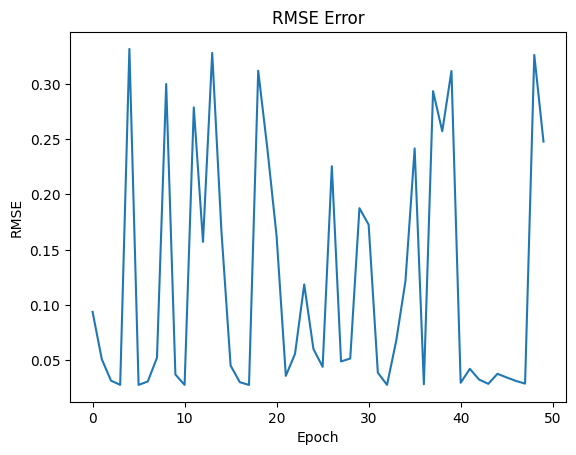

In [19]:
plt.title('RMSE Error')
plt.plot(errors)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
# plt.savefig('./output/img/Error_Plot_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')
plt.show()

#### Train results

In [21]:
# Extract optimal model parameters
opt_index = np.argmin(errors)
mf_params = dict(zip(['a','b','c','d'],[p.clone().detach() for p in cmf_params[opt_index]]))
# Instantiate optimal model
num_batches = 1
cmf = FuzzifyVariable(window, mf_params, nmfs)
opt_model = AncfisNet(window, cmf.forward(), nmfs)
opt_coeff = linear_coefficients[opt_index]
opt_model.coeff = opt_coeff
# Save opt_model
# torch.save(opt_model, './output/models')
# Use delay vector
dim = window
dataset = IterableData(dim, x_train, y_train, tao, delay=True,)
iterator = iter(dataset)
X_train,Y_train = next(iterator)
y_actual = Y_train
# delay_len = tao*(dim-1)
# X_train = delay_vector(x_train, 42, 15)
# Y_train = y_train[:len(y_train)-delay_len]
# print(X_train[:,1].shape)

# Compute predictions
y_pred = [opt_model(X_train[i,:].unsqueeze(0)) for i in range(X_train.shape[0])]
# 
# Save Data Plot
# pd.DataFrame({'Actual': y_actual, 'Pred': [y.item() for y in y_pred]}).to_csv('./output/NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.csv')

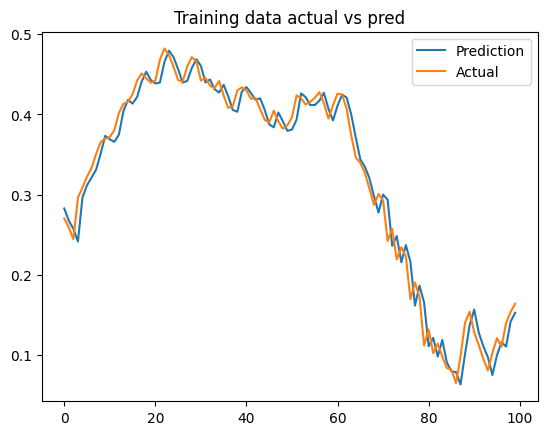

In [22]:
# Plot
plt.title('Training data actual vs pred')
plt.plot([y.detach().numpy() for y in y_pred][:100], label = 'Prediction')
plt.plot(y_actual[:100], label = 'Actual')
plt.legend()
# plt.savefig('./output/img/Train_first_100_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')
plt.show()

In [23]:
# Save optimal params in csv file
import os
out_dir = 'output'
file_name = 'Model_params_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.csv' 
os.makedirs(out_dir, exist_ok=True)
file = pd.DataFrame({'linear_coeff': [opt_coeff], 'mf_params': [mf_params], 'errors': [errors]})
# file.to_csv(os.path.join(out_dir, file_name))

In [24]:
def invert(norm_data):
    return [float(np.exp(y+ reg.predict(z.reshape(-1,1)))) if y!=0 else 0 for y,z in zip(norm_data, np.arange(len(norm_data)))]

#### Test results

torch.Size([2680, 40])


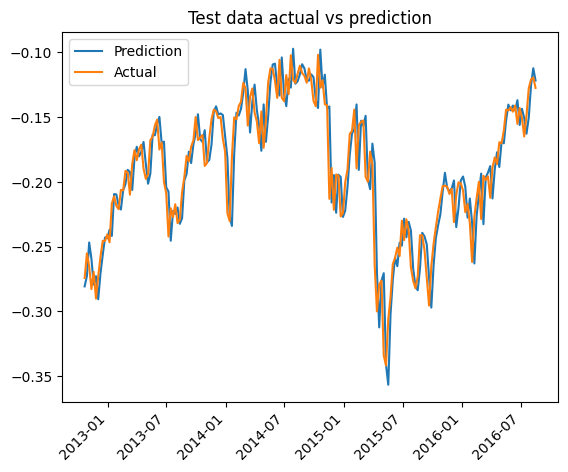

In [25]:
# Prepare test variables for forward pass
# Use delay vector
dataset = IterableData(window, torch.tensor(predictor), torch.tensor(outcome), delay=True)
iterator = iter(dataset)
X_test,Y_test = next(iterator)
print(X_test.shape)
# Compute test predictions
y_pred_test = [opt_model(X_test[i,:].unsqueeze(0)).item() for i in range(X_test.shape[0])]
y_actual_test = Y_test

test_date_index = data.index[train_test_index+1:train_test_index+201]
# Plot result
plt.title('Test data actual vs prediction')
plt.plot(test_date_index,[y for y in y_pred_test][train_test_index:train_test_index+200], label = 'Prediction')
plt.plot(test_date_index,y_actual_test[train_test_index:train_test_index+200], label = 'Actual')
plt.legend()
plt.xticks(rotation=45, ha='right')
# plt.savefig('./output/img/Weekly data lag 1 proto.png')
plt.show()

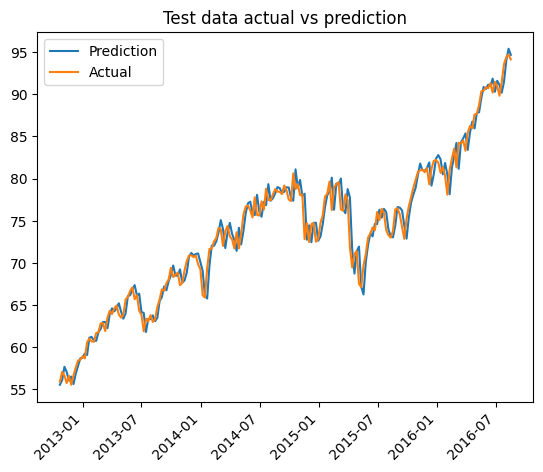

In [26]:
# plt.figure(figsize=((12,4))
plt.title('Test data actual vs prediction')
plt.plot(test_date_index,invert([y for y in y_pred_test][train_test_index:train_test_index+200]), label = 'Prediction')
plt.plot(test_date_index,invert(y_actual_test[train_test_index:train_test_index+200]), label = 'Actual')
plt.legend()
plt.xticks(rotation=45, ha='right')
# plt.savefig('./output/img/Test_first_200_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')
plt.show()

(array([ 730.,  912., 1096., 1277., 1461., 1642., 1826., 2007.]),
 [Text(730.0, 0, '1972-01'),
  Text(912.0, 0, '1972-07'),
  Text(1096.0, 0, '1973-01'),
  Text(1277.0, 0, '1973-07'),
  Text(1461.0, 0, '1974-01'),
  Text(1642.0, 0, '1974-07'),
  Text(1826.0, 0, '1975-01'),
  Text(2007.0, 0, '1975-07')])

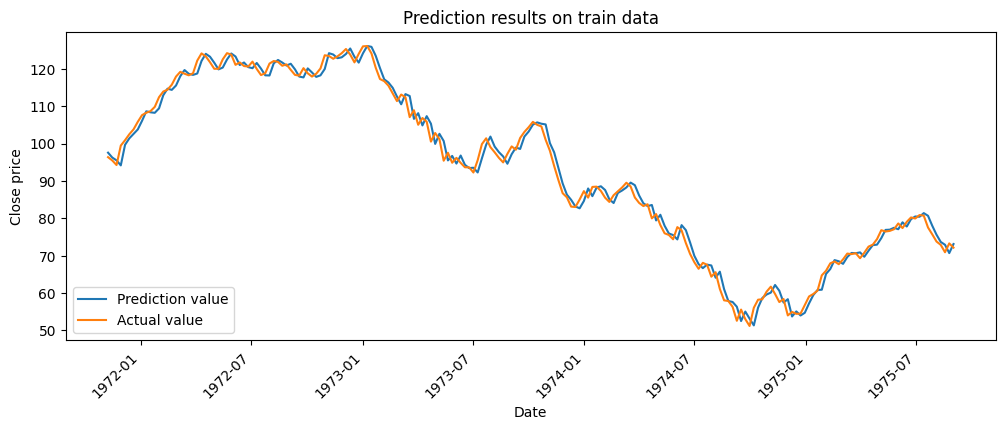

In [27]:
inv_trans = [float(np.exp(y+ reg.predict(z.reshape(-1,1)))) if y!=0 else 0 for y,z in zip(y_pred_test, np.arange(len(y_pred_test)))]
plt.figure(figsize=(12,4))
plt.title('Prediction results on train data')
plt.plot(close.index[window:window+200],inv_trans[:+200], label = 'Prediction value')
# plt.plot(close.shift(-1).values, label = 'Actual value', color = '#2657D9')
inv_trans_actual = [float(np.exp(y+ reg.predict(z.reshape(-1,1)))) for y,z in zip(y_actual_test, np.arange(len(y_actual_test)))]
plt.plot(close.index[window:window+200],inv_trans_actual[:+200], label = 'Actual value')
# plt.axvline(1751, color = 'black')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(loc='lower left')
plt.xticks(rotation=45, ha='right')
# plt.savefig('./output/img/Prediction_results_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')

In [ ]:
def equity(pred, actual):
    long = [0]
    short = [0]
    total = [0]
    for i in range(tao,len(pred)):
        if pred[i] >= pred[i-tao]:
            long.append(long[-1] + actual[i-tao+1]-actual[i-tao])
            total.append(total[-1] + actual[i-tao+1]-actual[i-tao])
            short.append(short[-1])
        else:
            long.append(long[-1])
            short.append(short[-1] + actual[i-tao]-actual[i-tao+1])
            total.append(total[-1] + actual[i-tao]-actual[i-tao+1])
    return long, short, total
long_equity, short_equity, total_equity = equity(inv_trans, inv_trans_actual)
buy_and_hold = close.values-close[-len(long_equity)]
plt.title('Long and short results on test data')
plt.plot(close.index[window*tao:],long_equity, label = 'Long')
plt.plot(close.index[window*tao:],short_equity, label = 'Short')
plt.plot(close.index[window*tao:],total_equity, label = 'Total')
plt.axvline(close.index[train_test_index], color ='red', linestyle = '--')
plt.legend()
# plt.savefig('./output/img/Long_short_results_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')
plt.show()

In [ ]:
plt.title('Results of Long Only Startegy vs buy and hold')
plt.plot(long_equity, label = 'Long Only Startegy Equity')
plt.axvline(train_test_index, color ='black')
plt.plot(buy_and_hold[-len(long_equity):], label = 'Buy and Hold')
# plt.savefig('./output/img/Long_Only_results_NSDQ_ANCFIS_LAG1_W40_NMFS3-lognorm.png')
plt.legend()

In [ ]:
buy_and_hold_test = close.values-close[train_test_index]
long_equity_test, short_equity_test, total_equity_test = equity(inv_trans[train_test_index-tao*window:], inv_trans_actual[train_test_index-tao*window:])
plt.title('Results of Long Only Startegy vs buy and hold test')
plt.plot(long_equity_test, label = 'Long Only Startegy Equity')
plt.plot(buy_and_hold_test[train_test_index:], label = 'Buy and Hold')
plt.legend()